In [1]:
import numpy as np 
import pandas as pd
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Rectangle
import sys
import xmltodict
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import time

In [2]:
torch.__version__

'1.7.1+cpu'

In [3]:
PATH_TO_DATASET = '../dataset'
PATH_TO_IMAGE = "../dataset/images"
PATH_TO_ANNOTATION = "../dataset/annotations"

In [4]:
def generate_box(obj):
    # print(obj)
    xmin = int(obj["bndbox"]["xmin"])
    ymin = int(obj["bndbox"]["ymin"])
    xmax = int(obj["bndbox"]["xmax"])
    ymax = int(obj["bndbox"]["ymax"])

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    """
    with mask -> 1
    wear incorrect or not wear -> 0
    """
    if obj["name"] == "with_mask":
        return 1
    elif obj["name"] == "without_mask" or obj["name"] == "mask_weared_incorrect":
        return 2
    else:
        return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = xmltodict.parse(f.read())
        
        objects = data["annotation"]["object"]
        
        # BBOX for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        if type(objects) == list:
            for i in objects:
                boxes.append(generate_box(i))
                labels.append(generate_label(i))
        else:
            boxes.append(generate_box(objects))
            labels.append(generate_label(objects))
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [5]:
imgs = list(sorted(os.listdir(PATH_TO_IMAGE)))
annotations = list(sorted(os.listdir(PATH_TO_ANNOTATION)))
print(imgs[:3], annotations[:3])

['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png'] ['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml']


In [6]:
class MaskDataset(Dataset):
    def __init__(self, transforms):
        super().__init__()
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(PATH_TO_IMAGE)))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(PATH_TO_IMAGE, file_image)
        label_path = os.path.join(PATH_TO_ANNOTATION, file_label)
        img = Image.open(img_path).convert("RGB")
        
        target = generate_target(idx, label_path)
        
        if self.transforms != None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [8]:
def collate_fn(batch):
    # print(*batch)
    return tuple(zip(*batch))

In [9]:
dataset = MaskDataset(data_transform)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print(f"Dataset Length: {len(dataset)}, train_size: {train_size}, test_size: {test_size}")

Dataset Length: 853, train_size: 682, test_size: 171


In [10]:
trainset, testset=torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(100))

In [11]:
trainDataLoader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate_fn)
testDataLoader = DataLoader(testset, batch_size=1, collate_fn=collate_fn)

In [12]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1)

    return model

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
model = get_model_instance_segmentation(2)

In [15]:
for imgs, annotations in trainDataLoader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[152., 100., 241., 182.]]), 'labels': tensor([1]), 'image_id': tensor([511])}, {'boxes': tensor([[ 11.,  89.,  53., 149.],
        [ 71.,  60., 122., 111.],
        [142., 117., 197., 167.],
        [265.,  53., 310., 104.]]), 'labels': tensor([1, 1, 1, 1]), 'image_id': tensor([466])}, {'boxes': tensor([[ 51., 144., 128., 239.],
        [147., 169., 217., 233.],
        [224.,  92., 309., 186.]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([138])}, {'boxes': tensor([[ 27.,  81.,  33.,  86.],
        [122.,  80., 142., 104.],
        [249.,  57., 275.,  86.]]), 'labels': tensor([2, 1, 1]), 'image_id': tensor([538])}, {'boxes': tensor([[ 66., 205., 156., 330.]]), 'labels': tensor([1]), 'image_id': tensor([851])}, {'boxes': tensor([[124., 121., 213., 264.]]), 'labels': tensor([1]), 'image_id': tensor([791])}, {'boxes': tensor([[105.,  23., 170.,  96.]]), 'labels': tensor([1]), 'image_id': tensor([28])}, {'boxes': tensor([[126.,  62., 147.,  91.],
        [184.,  91

## Train

In [16]:
num_epochs = 50
model.to(device)
loss_log = []
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
batches = len(trainDataLoader)
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time_epoch = time.time()
    for i, (imgs, annotations) in enumerate(trainDataLoader):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        if i % 1 == 0:
            print(f"Epoch: {epoch}, Batch: {i}/{batches}, Loss: {losses}")
        epoch_loss += losses
    end_time_epoch = time.time()
    print(f"Epoch {epoch} total loss: {epoch_loss}, time: {end_time_epoch - start_time_epoch}")
    loss_log.append(epoch_loss)
    print("----------")

end_time = time.time()
print(f"Running time {end_time - start_time}")

torch.save(model.state_dict(),'./model2_2.pt')

Epoch: 0, Batch: 1/22, Loss: 1.6668521165847778
Epoch: 0, Batch: 2/22, Loss: 0.9308066368103027
Epoch: 0, Batch: 3/22, Loss: 0.7872645258903503
Epoch: 0, Batch: 4/22, Loss: 0.6497306823730469
Epoch: 0, Batch: 5/22, Loss: 0.6615375280380249
Epoch: 0, Batch: 6/22, Loss: 1.0708036422729492
Epoch: 0, Batch: 7/22, Loss: 0.8559707999229431
Epoch: 0, Batch: 8/22, Loss: 0.6689285635948181
Epoch: 0, Batch: 9/22, Loss: 0.6878370046615601
Epoch: 0, Batch: 10/22, Loss: 0.746751606464386
Epoch: 0, Batch: 11/22, Loss: 0.5676494836807251
Epoch: 0, Batch: 12/22, Loss: 0.6418879628181458
Epoch: 0, Batch: 13/22, Loss: 0.7277923226356506
Epoch: 0, Batch: 14/22, Loss: 0.6502349376678467
Epoch: 0, Batch: 15/22, Loss: 0.5933074951171875
Epoch: 0, Batch: 16/22, Loss: 0.5580320358276367
Epoch: 0, Batch: 17/22, Loss: 0.6882907152175903
Epoch: 0, Batch: 18/22, Loss: 0.6394564509391785
Epoch: 0, Batch: 19/22, Loss: 0.7348213195800781
Epoch: 0, Batch: 20/22, Loss: 0.6587169170379639
Epoch: 0, Batch: 21/22, Loss: 

KeyboardInterrupt: 

In [17]:
torch.save(model.state_dict(), './model2_3.pth')

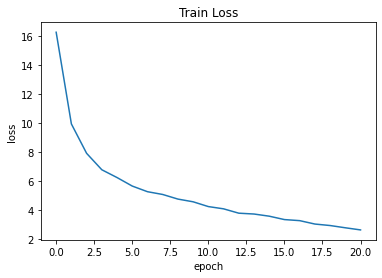

In [19]:
loss_record=[
    52.99475860595703, 40.772029876708984, 29.405611038208008, 30.507911682128906, 32.67216110229492, 
    26.49441146850586, 20.494503021240234, 24.44652557373047, 25.322792053222656, 25.898418426513672,
    23.598398208618164, 22.025501251220703, 19.358423233032227, 24.80889320373535, 21.606704711914062,
    20.622028350830078, 22.94870376586914, 23.799055099487305, 23.186620712280273, 21.728010177612305]
plt.plot(loss_log)
plt.xlabel('epoch') 
plt.ylabel('loss') 
  
# displaying the title
plt.title("Train Loss")
plt.savefig("./train_loss.jpg")

## Evaluation

In [17]:
model.load_state_dict(torch.load("./model2.pt"))

<All keys matched successfully>

In [50]:
for i, (imgs, annotations) in enumerate(testDataLoader):
    if i<6:
        continue
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break
print(annotations)

[{'boxes': tensor([[328.,  33., 350.,  57.],
        [366.,  70., 384.,  92.],
        [249.,  44., 268.,  63.],
        [278.,  71., 292.,  87.],
        [ 29.,  47.,  46.,  67.],
        [ 37.,  63.,  59.,  88.],
        [179.,  40., 205.,  67.],
        [ 68.,  67.,  90.,  91.],
        [  1.,  46.,  18.,  63.],
        [137.,  57., 155.,  76.],
        [235.,  51., 249.,  67.],
        [282.,  33., 301.,  51.],
        [ 89.,  54., 103.,  71.]]), 'labels': tensor([1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]), 'image_id': tensor([545])}]


In [51]:
model.eval()
preds = model(imgs)

In [52]:
preds

[{'boxes': tensor([[249.9832,  42.8820, 266.5599,  61.4437],
          [  1.2130,  45.2467,  18.2698,  63.4744],
          [326.7342,  32.6348, 351.9165,  57.5700],
          [136.8993,  57.8376, 154.4884,  73.9264],
          [ 67.3547,  68.2111,  90.4481,  90.7428],
          [232.7491,  49.1897, 249.6884,  67.5629],
          [280.2490,  33.1130, 299.7783,  50.8245],
          [277.2512,  71.7323, 290.2715,  86.0724],
          [ 86.4761,  53.6397, 101.9398,  70.4164],
          [ 28.6003,  48.1373,  46.7567,  64.0317],
          [180.6405,  40.7235, 203.8996,  66.6297],
          [366.6154,  70.4491, 383.4053,  91.3770],
          [ 36.3091,  63.3976,  59.0144,  85.8396],
          [366.2438,  70.3491, 384.0944,  92.6243],
          [ 36.3606,  63.9689,  58.4425,  86.6203],
          [ 66.2816, 115.2815,  79.9658, 133.9061],
          [319.0389,   7.8324, 330.0822,  19.4417],
          [179.8452,  41.4493, 204.6811,  67.7053],
          [321.8594,   6.3608, 330.3086,  16.1405],
   

In [53]:
def plot_image(img_tensor, annotation, threshold=None):
    
    fig, ax = plt.subplots(1)
    img = img_tensor.cpu().data
    framecolor={1: 'g', 2: 'r', 0: 'b'}

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    if not threshold:
        annotation["scores"] = [1.0] * len(annotation["labels"])
    
    for box, label, score in zip(annotation["boxes"], annotation["labels"], annotation["scores"]):
        xmin, ymin, xmax, ymax = box
        xmin = float(xmin)
        ymin = float(ymin)
        xmax = float(xmax)
        ymax = float(ymax)
        label = int(label)
        score = float(score)

        if threshold and score < threshold:
            continue
        # Create a Rectangle patch
        rect = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                  linewidth=1, edgecolor=framecolor[label], facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


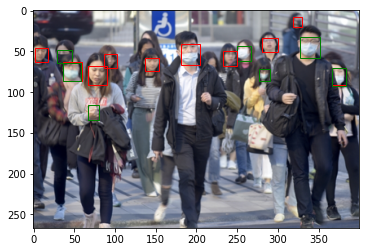

Target


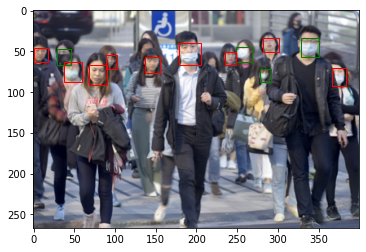

In [54]:
print("Prediction")
plot_image(imgs[0], preds[0], 0.5)
print("Target")
plot_image(imgs[0], annotations[0])